In [19]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [20]:
import wntr
import pandas as pd
import numpy as np
import copy
import networkx as nx
import torch
from wntr.graphics import plot_network
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from IPython.display import display, Markdown


In [21]:
inp_file = 'tsnet.inp'

### Network Topology Without Leak Junctions

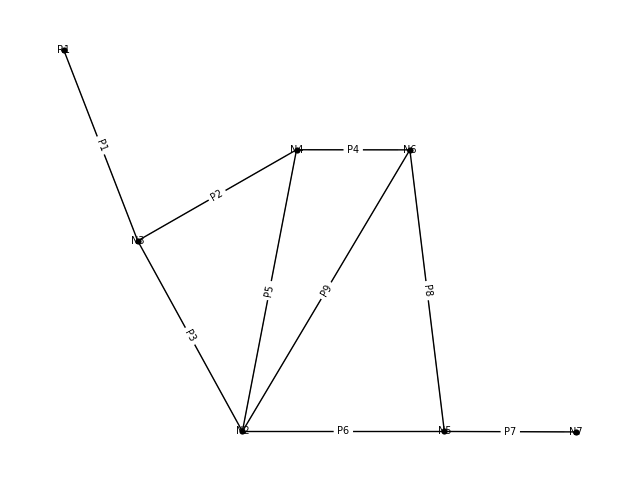

In [22]:
# Plot just the structure of the network
base_wn = wntr.network.WaterNetworkModel(inp_file)

display(Markdown("### Network Topology Without Leak Junctions"))

fig, ax = plt.subplots(figsize=(8, 6))
plot_network(base_wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [23]:
pipe_names = base_wn.pipe_name_list
n_pipes = len(base_wn.pipe_name_list)
leak_junctions = [f'LEAK-{i}' for i in range(n_pipes)] 

In [24]:
split_wn = copy.deepcopy(base_wn)
for i, pn in enumerate(pipe_names):
    split_wn = wntr.morph.split_pipe(split_wn, pn, pn + '_B', f'LEAK-{i}')

In [25]:
Cd = 0.75
diameter = 1

base_leak = 0

leak_ratio = np.array([0.3])
leak_areas = 3.14159 * (diameter*leak_ratio / 2) ** 2

supply_nodes = base_wn.reservoir_name_list
flow_data = []
leak_junctions = [f'LEAK-{i}' for i in range(n_pipes)] 


wn = copy.deepcopy(split_wn)
results = wntr.sim.WNTRSimulator(wn).run_sim()
flow = results.link['flowrate'].iloc[0] 
flow_row = {'Leak Node ID' : None, 'Leak Area': 0}
flow_row.update(flow)
flow_data.append(flow_row)

for i, pipe_name in enumerate(pipe_names):
    
    print(f'{i+1}/{n_pipes}', end="\r", flush=True)

    for area in leak_areas:
        wn = copy.deepcopy(split_wn)
        
        leak_node_id = f'LEAK-{i}'
        
        #wn = wntr.morph.split_pipe(base_wn, pipe_name, 'virtual-pipe', leak_node_id)

        # Add leak at specified node
        wn.get_node(leak_node_id).add_leak(wn, area=area, discharge_coeff=Cd, start_time=0)

        # Run simulation
        results = wntr.sim.WNTRSimulator(wn).run_sim()

        # Get flow at t=0
        flow = results.link['flowrate'].iloc[0] 
        

        # Add to results
        flow_row = {'Leak Node ID' : leak_node_id, 'Leak Area': area}
        flow_row.update(flow)
        flow_data.append(flow_row)

flow_df = pd.DataFrame(flow_data)
display(flow_df)


,Leak Node ID,Leak Area,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
0,None,0.000000,2.000000,0.928931,1.071069,0.282373,0.146559,-0.439447,1.0000,0.560553,0.278180,2.000000,0.928931,1.071069,0.282373,0.146559,-0.439447,1.0,0.560553,0.278180
1,LEAK-0,0.070686,5.111707,0.928931,1.071069,0.282373,0.146559,-0.439447,1.0000,0.560553,0.278180,2.000000,0.928931,1.071069,0.282373,0.146559,-0.439447,1.0,0.560553,0.278180
2,LEAK-1,0.070686,4.936535,2.803055,2.133481,-0.167774,-0.465706,-0.517251,1.0000,0.482749,0.650523,4.936535,-0.133481,2.133481,-0.167774,-0.465706,-0.517251,1.0,0.482749,0.650523
3,LEAK-2,0.070686,4.938325,1.808278,3.130046,0.698655,0.609624,-0.414562,1.0000,0.585438,-0.113216,4.938325,1.808278,0.191722,0.698655,0.609624,-0.414562,1.0,0.585438,-0.113216
4,LEAK-3,0.070686,4.906098,2.293723,2.612375,1.851166,-0.057443,-0.755075,1.0000,0.244925,1.299856,4.906098,2.293723,2.612375,-1.054932,-0.057443,-0.755075,1.0,0.244925,1.299856
5,LEAK-4,0.070686,4.907979,2.289034,2.618945,0.314379,1.474656,-0.435703,1.0000,0.564297,0.249918,4.907979,2.289034,2.618945,0.314379,-1.433323,-0.435703,1.0,0.564297,0.249918
6,LEAK-5,0.070686,4.887609,2.233343,2.654266,1.024596,0.708747,0.755775,1.0000,1.755775,0.731179,4.887609,2.233343,2.654266,1.024596,0.708747,-2.131834,1.0,1.755775,0.731179
7,LEAK-6,0.070686,4.783700,2.197225,2.586475,1.093294,0.603931,-1.659733,3.7837,2.123967,1.030672,4.783700,2.197225,2.586475,1.093294,0.603931,-1.659733,1.0,2.123967,1.030672
8,LEAK-7,0.070686,4.889288,2.253207,2.636081,1.201802,0.551405,-1.422316,1.0000,2.466972,1.265170,4.889288,2.253207,2.636081,1.201802,0.551405,-1.422316,1.0,-0.422316,1.265170
9,LEAK-8,0.070686,4.907581,2.259028,2.648553,1.181866,0.577162,-0.714287,1.0000,0.285713,2.011428,4.907581,2.259028,2.648553,1.181866,0.577162,-0.714287,1.0,0.285713,-0.896153


In [26]:
Q = torch.tensor(results.link['flowrate'].iloc[0].to_numpy(), dtype=torch.float32)
#H = torch.tensor(results.node['pressure'].iloc[0][:-2].to_numpy(), dtype=torch.float32)

In [27]:
leak_ratio = np.array([0.3])
leak_areas = 3.14159 * (diameter*leak_ratio / 2) ** 2
model_params = get_model_parameters(base_wn, results)

demand_idx = model_params['demand_idx']

net_params = {
        'layer_sizes' : [1,96,96,96,96,1], 
        'activation' : 'tanh',
        'base' : Q,
}


In [28]:
def d_leak(a, H):
        d = Cd * a * torch.sqrt(2 * g * relu(H))
        return d
    
def hL(q):
    return torch.sign(q) * 10.667 * model_params['C']**(-1.852) * model_params['d']**(-4.871) * model_params['L'] * torch.abs(q)**(1.852)

def mv(M, v):
    return (M @ v.T).T
    
mse = lambda x : (x**2).mean()


demand = torch.zeros(1, model_params['A0'].shape[0])
demand[:,model_params['demand_idx']] = torch.tensor(model_params['D'])


idx = torch.tensor([[-1]])
batch_idx = torch.arange(1).unsqueeze(1).expand_as(idx)

areas = torch.zeros((1, n_pipes))
areas[batch_idx,idx] = leak_areas[0] 


A0 = model_params['A0']

B = model_params['B']
S = model_params['S']

M = model_params['M']

inv = model_params['inv']

supply = B @ S

hL = hL(Q)    
H = mv(inv, supply - hL)
 
print(mv(M, areas).shape)
print(A0.T.shape)
print(H.shape)
print(Q.shape)
mse(A0 @ Q - demand - d_leak(mv(M, areas), H))

torch.Size([1, 15])
torch.Size([18, 15])
torch.Size([15])
torch.Size([18])


tensor(1.6792e-08)

In [29]:
model = Model(model_params, net_params)
model.train(iterations=100000, print_interval=100)

step       loss      
100        3.33e-02   New Best!
200        7.32e-02   
300        1.10e-02   New Best!
400        2.52e-01   
500        1.72e-02   
600        3.91e-02   
700        1.21e-01   
800        1.49e-02   
900        1.01e-02   New Best!
1000       1.52e-02   
1100       5.41e-03   New Best!
1200       1.89e-01   
1300       1.60e-05   New Best!
1400       3.18e-03   
1500       1.15e-02   
1600       9.13e-04   
1700       6.51e-04   
1800       1.43e-02   
1900       5.26e-02   
2000       6.75e-02   
2100       3.40e-03   
2200       1.32e-02   
2300       6.63e-02   
2400       1.83e-03   
2500       3.46e-02   
2600       8.01e-03   
2700       2.30e-03   
2800       1.16e-01   
2900       5.17e-05   
3000       7.23e-02   
3100       5.93e-02   
3200       9.52e-02   
3300       6.30e-05   
3400       1.08e-01   
3500       6.64e-04   
3600       3.33e-04   
3700       6.96e-02   
3800       7.73e-02   
3900       4.32e-02   
4000       7.34e-05   
4100       7.

KeyboardInterrupt: 

Best loss: tensor(1.3776e-11, grad_fn=<MeanBackward0>)
[ 2.     0.929  1.071  0.282  0.147 -0.439  1.     0.561  0.278  2.     0.929  1.071  0.282  0.147 -0.439  1.     0.561  0.278]


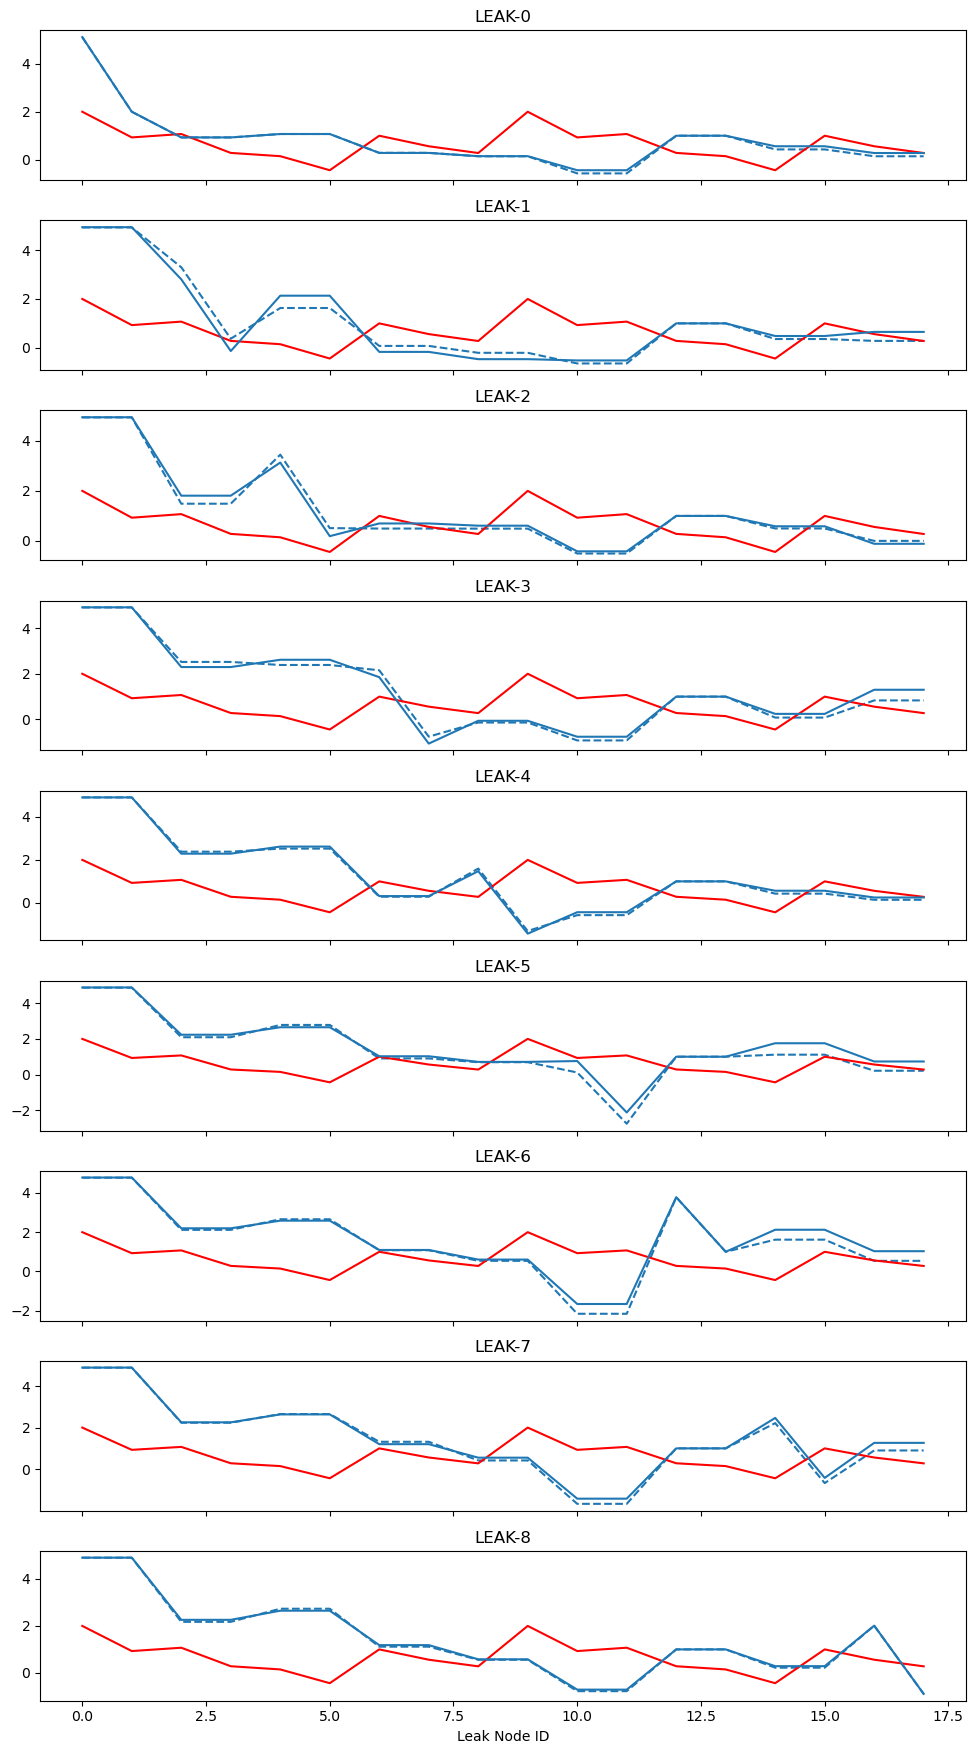

In [38]:
model.eval()
true_df = flow_df.drop(columns=['Leak Area'])

fig, axs = plt.subplots(n_pipes, 1, figsize=(10, 2 * n_pipes), sharex=True)
axs = np.atleast_1d(axs)

ind = np.argsort(wn.pipe_name_list, axis=0)



# Only store legend handles/labels once
legend_handles = []

qs = []
trues = []

no_leak = flow_df.drop(columns=['Leak Area', 'Leak Node ID']).iloc[0].to_numpy()
print(no_leak)

for i in range(n_pipes):
    
    
    leak_id = torch.tensor([i], dtype=torch.float32).reshape(1,-1)
    D = torch.tensor(results.node['demand'].iloc[0][wn.junction_name_list].values, dtype=torch.float32)[demand_idx].reshape(1,-1)
    demand = torch.zeros(1, model.A0.shape[0])
    demand[:,demand_idx] = D
    
    out = torch.zeros(1, model.A0.shape[0])
    
    leak_idx = leak_id.long()
    global_idx = (6.0+leak_idx).long()
    batch_global = torch.arange(1).unsqueeze(1).expand_as(global_idx)
    batch_leak = torch.arange(1).unsqueeze(1).expand_as(leak_idx)



    input = torch.cat((D, leak_id), dim=-1)
    out[batch_global,global_idx] = model.net(leak_id)
    
            
    q_torch = model.mv(model.inv.T, out+demand)
    
    H = model.mv(model.inv, model.supply - model.hL(q_torch)  )
    
    q = q_torch.detach().numpy()
    
    true_df = flow_df[flow_df['Leak Node ID'] == f'LEAK-{i}'].drop(columns=['Leak Node ID'])
    true = true_df.drop(columns=['Leak Area']).to_numpy()
    pipe_names = list(flow_df.columns[2:])
    
    q_df = pd.DataFrame(q, columns=pipe_names)
    error_df = pd.DataFrame(q - true, columns=pipe_names)
    
    
    lines = axs[i].plot(np.arange(2*n_pipes), q.T[ind], '--', alpha=1.0)  # Store the Line2D objects
    axs[i].plot(np.arange(2*n_pipes), no_leak, '-', alpha=1.0, color='red')
    
    for j, line in enumerate(lines):
        color = line.get_color()  # Get color from first plot
        axs[i].plot(np.arange(2*n_pipes), true[j,ind], '-', color=color, alpha=1.0)
        #axs[i].plot(np.arange(2*n_pipes), true[j,:], '-', color=color, alpha=0.1)  # Use same color
        #axs[i].plot(np.arange(2*n_pipes), true[-1,:], 'o', color=l[j].get_color(), alpha=0.5)
        axs[i].set_title(f'LEAK-{i}')

axs[-1].set_xlabel("Leak Node ID")
fig.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend
plt.show()


In [31]:
display(q_df)
display(true_df)
display(error_df)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
0,4.90671,2.174305,2.732406,1.116204,0.558101,-0.779051,1.0,0.220947,2.01146,4.906711,2.174306,2.732407,1.116204,0.558102,-0.779051,0.999999,0.220947,-0.895253


,Leak Area,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
9,0.070686,4.907581,2.259028,2.648553,1.181866,0.577162,-0.714287,1.0,0.285713,2.011428,4.907581,2.259028,2.648553,1.181866,0.577162,-0.714287,1.0,0.285713,-0.896153


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P1_B,P2_B,P3_B,P4_B,P5_B,P6_B,P7_B,P8_B,P9_B
0,-0.000871,-0.084723,0.083853,-0.065662,-0.019061,-0.064764,-3.576279e-07,-0.064766,0.000031,-0.00087,-0.084722,0.083854,-0.065661,-0.01906,-0.064764,-0.000001,-0.064766,0.000899


In [32]:
# def get_upstream_idx(G, start_node, visited=None):
#     if visited is None:
#         visited = set()

#     if start_node in visited:
#         return []

#     visited.add(start_node)
#     upstream_idx = []

#     for n in G.predecessors(start_node):
#         idx = np.where((edgelist == [n, start_node]).sum(-1) == 2)[0].item()
#         upstream_idx.append(idx)
#         upstream_idx += get_upstream_idx(G, n, visited)

#     return upstream_idx

# U = torch.zeros(2*n_pipes, n_pipes)
# for i in range(n_pipes):
#     print(f'Doing LEAK-{i}...')
#     affected = get_upstream_idx(wn.to_graph(), f'LEAK-{i}')
#     U[affected, i] = 1
#     print(f'LEAK-{i} done!')